In [1]:
!pip install openai faiss-cpu numpy tiktoken PyMuPDF python-dotenv


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: C:\Users\TempAccess\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [2]:
import os
import time
import random
from typing import List, Dict, Tuple
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
os.chdir(r"C:\Users\TempAccess\Documents\Dhruv\RAG")
print(os.getcwd())

C:\Users\TempAccess\Documents\Dhruv\RAG


In [4]:
from helper_function_openai import (
    Document,
    OpenAIEmbedder,
    FAISSVectorStore,
    OpenAIChat,
    read_pdf_with_metadata,
    chunk_documents,
)

print("Helpers imported successfully")

Helpers imported successfully


In [5]:
pdf_read = r"C:\Users\TempAccess\Documents\Dhruv\RAG\data\Understanding_Climate_Change.pdf"
documents = read_pdf_with_metadata(pdf_read)
documents

[Document(content='Understanding Climate Change \nChapter 1: Introduction to Climate Change \nClimate change refers to significant, long-term changes in the global climate. The term \n"global climate" encompasses the planet\'s overall weather patterns, including temperature, \nprecipitation, and wind patterns, over an extended period. Over the past century, human \nactivities, particularly the burning of fossil fuels and deforestation, have significantly \ncontributed to climate change. \nHistorical Context \nThe Earth\'s climate has changed throughout history. Over the past 650,000 years, there have \nbeen seven cycles of glacial advance and retreat, with the abrupt end of the last ice age about \n11,700 years ago marking the beginning of the modern climate era and human civilization. \nMost of these climate changes are attributed to very small variations in Earth\'s orbit that \nchange the amount of solar energy our planet receives. During the Holocene epoch, which \nbegan at the end

In [6]:
print(f"Loaded {len(documents)} pages from PDF")
print(f"Sample (page 1, first 200 chars): {documents[0].content[:200]}...")

Loaded 33 pages from PDF
Sample (page 1, first 200 chars): Understanding Climate Change 
Chapter 1: Introduction to Climate Change 
Climate change refers to significant, long-term changes in the global climate. The term 
"global climate" encompasses the plane...


In [7]:
eval_documents = documents[:20]
print(f"Using {len(eval_documents)} pages for evaluation")

Using 20 pages for evaluation


In [8]:
## lets generate evaluation questions by using openai
evaluator_llm = OpenAIChat(model_name="gpt-4o", temperature=0)

def generate_eval_questions(
    documents:List[Document],
    num_questions:int,
    questions_per_chunk:int=2   
)-> List[str]:
    """
    Generate evaluation questions from document content.
    
    Replaces: LlamaIndex DatasetGenerator.from_documents()
    
    Strategy: sample a subset of pages, ask GPT-4o to generate
    questions that can be answered from each page's content.
    """
    all_questions = []

    pages_to_use = random.sample(documents, min(len(documents), num_questions//questions_per_chunk))

    for docs in pages_to_use:

        content = docs.content[:3000]

        messages = [
            {
                "role": "system",
                "content": (
                    "You are an expert at generating evaluation questions for RAG systems. "
                    "Given a document passage, generate questions that can be answered "
                    "ONLY using information in the passage. "
                    "Questions should be specific, factual, and answerable from the text."
                )
            },
            {
                "role": "user",
                "content": (
                    f"Generate exactly {questions_per_chunk} evaluation questions based on this passage.\n"
                    f"Return ONLY the questions, one per line, no numbering.\n\n"
                    f"Passage:\n{content}"
                )
            }
        ]

        response = evaluator_llm.chat(messages)
        
        # Parse questions (one per line)
        questions = [
            q.strip() for q in response.strip().split("\n")
            if q.strip() and len(q.strip()) > 10
        ]
        all_questions.extend(questions)
    
    return all_questions

In [9]:
num_eval_questions = 25

print("Generating evaluation questions from documents...")
eval_questions = generate_eval_questions(eval_documents, num_questions=40)

# Sample k questions (same as original)
k_eval_questions = random.sample(eval_questions, min(num_eval_questions, len(eval_questions)))

print(f"\nGenerated {len(eval_questions)} total questions")
print(f"Selected {len(k_eval_questions)} for evaluation")
print(f"\nSample questions:")
for q in k_eval_questions[:5]:
    print(f"  • {q}")

Generating evaluation questions from documents...

Generated 40 total questions
Selected 25 for evaluation

Sample questions:
  • What are some applications of AI and machine learning mentioned in the passage?
  • What evidence do scientists use to understand past climate conditions and predict future trends?
  • How can effective climate communication raise awareness and inspire action as described in the passage?
  • What are some products that can be made using captured CO2 according to the passage?
  • What role do grassroots movements play in advocating for climate action according to the passage?


In [10]:
def evaluate_faithfulness(answer: str, context: str) -> bool:
    """
    Check if the answer is supported by the context.
    
    Replaces: LlamaIndex FaithfulnessEvaluator
    Uses the exact same prompt logic from the original notebook.
    
    Returns:
        True if faithful, False otherwise
    """
    messages = [
        {
            "role": "system",
            "content": "You are an evaluator. Answer only YES or NO."
        },
        {
            "role": "user",
            "content": (
                "Please tell if a given piece of information is directly supported by the context.\n"
                "You need to answer with either YES or NO.\n"
                "Answer YES if any part of the context explicitly supports the information, "
                "even if most of the context is unrelated. "
                "If the context does not explicitly support the information, answer NO.\n\n"
                "Some examples are provided below.\n\n"
                "Information: Apple pie is generally double-crusted.\n"
                "Context: An apple pie is a fruit pie in which the principal filling ingredient is apples. "
                "Apple pie is often served with whipped cream, ice cream, custard, or cheddar cheese. "
                "It is generally double-crusted, with pastry both above and below the filling; "
                "the upper crust may be solid or latticed.\n"
                "Answer: YES\n\n"
                "Information: Apple pies taste bad.\n"
                "Context: An apple pie is a fruit pie in which the principal filling ingredient is apples. "
                "Apple pie is often served with whipped cream, ice cream, custard, or cheddar cheese. "
                "It is generally double-crusted, with pastry both above and below the filling.\n"
                "Answer: NO\n\n"
                "Information: Paris is the capital of France.\n"
                "Context: This document describes a day trip in Paris. You will visit famous landmarks "
                "like the Eiffel Tower, the Louvre Museum, and Notre-Dame Cathedral.\n"
                "Answer: NO\n\n"
                f"Information: {answer}\n"
                f"Context: {context}\n"
                "Answer:"
            )
        }
    ]
    
    result = evaluator_llm.chat(messages, max_tokens=10)
    return "YES" in result.upper()


def evaluate_relevancy(question: str, answer: str, context: str) -> bool:
    """
    Check if the answer is relevant to the question.
    
    Replaces: LlamaIndex RelevancyEvaluator
    
    Returns:
        True if relevant, False otherwise
    """
    messages = [
        {
            "role": "system",
            "content": "You are an evaluator. Answer only YES or NO."
        },
        {
            "role": "user",
            "content": (
                "Given the following question, context, and answer, determine if the answer "
                "is relevant to the question and supported by the context.\n\n"
                f"Question: {question}\n\n"
                f"Context: {context}\n\n"
                f"Answer: {answer}\n\n"
                "Is the answer relevant to the question? Answer YES or NO."
            )
        }
    ]
    
    result = evaluator_llm.chat(messages, max_tokens=10)
    return "YES" in result.upper()

In [11]:
def build_rag_for_chunk_size(
    documents: List[Document],
    chunk_size: int,
    embedding_model: str = "text-embedding-3-small"
) -> Tuple[FAISSVectorStore, OpenAIEmbedder]:
    """
    Build a complete RAG index for a given chunk size.
    
    Replaces:
        Settings.chunk_size = chunk_size
        VectorStoreIndex.from_documents(eval_documents)
    
    Returns:
        (vector_store, embedder) tuple
    """
    chunk_overlap = chunk_size // 5  # Same ratio as original
    
    # Chunk documents with the specified size
    chunked_docs = chunk_documents(documents, chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    
    # Embed all chunks
    embedder = OpenAIEmbedder(model=embedding_model)
    chunked_docs = embedder.embed_documents(chunked_docs)
    
    # Build FAISS index
    vector_store = FAISSVectorStore(dimension=embedder.dimension)
    vector_store.add_documents(chunked_docs)
    
    return vector_store, embedder


def query_rag(
    question: str,
    vector_store: FAISSVectorStore,
    embedder: OpenAIEmbedder,
    chat_llm: OpenAIChat,
    k: int = 5
) -> Tuple[str, str]:
    """
    Query the RAG pipeline and return (answer, context).
    
    Replaces: query_engine.query(question)
    
    Returns:
        (answer, context_text)
    """
    # Retrieve
    query_embedding = embedder.embed_text(question)
    results = vector_store.search(query_embedding, k=k)
    
    # Build context
    context_parts = [r.document.content for r in results]
    context_text = "\n\n---\n\n".join(context_parts)
    
    # Generate answer
    system_prompt = (
        "You are a helpful assistant that answers questions based on the provided context. "
        "Answer ONLY based on the context. If the answer cannot be found, say so. "
        "Be concise but complete."
    )
    
    answer = chat_llm.chat_with_context(
        query=question,
        context=context_parts,
        system_prompt=system_prompt
    )
    
    return answer, context_text

In [12]:
def evaluate_chunk_size(
    chunk_size: int,
    eval_questions: List[str],
    documents: List[Document],
    verbose: bool = True
) -> Dict[str, float]:
    """
    Evaluate a specific chunk size across all metrics.
    
    Replaces: evaluate_response_time_and_accuracy()
    
    Uses:
    - gpt-4o-mini for response generation (fast + cheap)
    - gpt-4o for evaluation (accurate grading)
    
    Returns:
        Dict with avg_response_time, avg_faithfulness, avg_relevancy, num_chunks
    """
    if verbose:
        print(f"\n{'='*60}")
        print(f"Evaluating chunk_size={chunk_size}")
        print(f"{'='*60}")
    
    # Build the RAG index for this chunk size
    vector_store, embedder = build_rag_for_chunk_size(documents, chunk_size)
    num_chunks = vector_store.index.ntotal
    
    if verbose:
        print(f"  Indexed {num_chunks} chunks (chunk_size={chunk_size}, overlap={chunk_size // 5})")
    
    # Response generation LLM (fast model)
    response_llm = OpenAIChat(
        model_name="gpt-4o-mini",
        temperature=0.0,
        max_tokens=500
    )
    
    total_time = 0
    total_faithfulness = 0
    total_relevancy = 0
    num_questions = len(eval_questions)
    
    for i, question in enumerate(eval_questions):
        # Measure response time (embed + search + generate)
        start = time.time()
        answer, context = query_rag(question, vector_store, embedder, response_llm, k=5)
        elapsed = time.time() - start
        
        # Evaluate faithfulness (is answer supported by context?)
        faithful = evaluate_faithfulness(answer, context)
        
        # Evaluate relevancy (does answer address the question?)
        relevant = evaluate_relevancy(question, answer, context)
        
        total_time += elapsed
        total_faithfulness += int(faithful)
        total_relevancy += int(relevant)
        
        if verbose:
            status = "✓" if (faithful and relevant) else "✗"
            print(f"  [{i+1}/{num_questions}] {status} time={elapsed:.2f}s faith={faithful} rel={relevant} | {question[:60]}...")
    
    results = {
        "chunk_size": chunk_size,
        "num_chunks": num_chunks,
        "avg_response_time": total_time / num_questions,
        "avg_faithfulness": total_faithfulness / num_questions,
        "avg_relevancy": total_relevancy / num_questions
    }
    
    if verbose:
        print(f"\n  Results for chunk_size={chunk_size}:")
        print(f"    Chunks: {num_chunks}")
        print(f"    Avg Response Time: {results['avg_response_time']:.2f}s")
        print(f"    Avg Faithfulness:  {results['avg_faithfulness']:.2f}")
        print(f"    Avg Relevancy:     {results['avg_relevancy']:.2f}")
    
    return results

In [13]:
chunk_sizes = [128, 256, 512, 1024]

all_results = []

for chunk_size in chunk_sizes:
    result = evaluate_chunk_size(
        chunk_size=chunk_size,
        eval_questions=k_eval_questions,
        documents=eval_documents,
        verbose=True
    )
    all_results.append(result)


Evaluating chunk_size=128
  Indexed 477 chunks (chunk_size=128, overlap=25)
  [1/25] ✓ time=1.28s faith=True rel=True | What are some applications of AI and machine learning mentio...
  [2/25] ✓ time=0.96s faith=True rel=True | What evidence do scientists use to understand past climate c...
  [3/25] ✓ time=1.46s faith=True rel=True | How can effective climate communication raise awareness and ...
  [4/25] ✓ time=1.04s faith=True rel=True | What are some products that can be made using captured CO2 a...
  [5/25] ✓ time=1.41s faith=True rel=True | What role do grassroots movements play in advocating for cli...
  [6/25] ✓ time=1.22s faith=True rel=True | What are the benefits of establishing and managing protected...
  [7/25] ✓ time=1.14s faith=True rel=True | What are some of the emerging technologies mentioned in the ...
  [8/25] ✓ time=1.35s faith=True rel=True | What are the primary uses of oil and the environmental impac...
  [9/25] ✓ time=1.12s faith=True rel=True | What are some p

In [14]:
# Summary table
print(f"\n{'='*80}")
print(f"CHUNK SIZE COMPARISON")
print(f"{'='*80}")
print(f"{'Chunk Size':>12} {'Chunks':>8} {'Avg Time (s)':>14} {'Faithfulness':>14} {'Relevancy':>12}")
print(f"{'-'*12:>12} {'-'*8:>8} {'-'*14:>14} {'-'*14:>14} {'-'*12:>12}")

for r in all_results:
    print(
        f"{r['chunk_size']:>12} "
        f"{r['num_chunks']:>8} "
        f"{r['avg_response_time']:>14.2f} "
        f"{r['avg_faithfulness']:>14.2f} "
        f"{r['avg_relevancy']:>12.2f}"
    )

# Find the best chunk size
best = max(all_results, key=lambda x: (x['avg_faithfulness'] + x['avg_relevancy']) / 2)
print(f"\n→ Best chunk size: {best['chunk_size']} "
      f"(faithfulness={best['avg_faithfulness']:.2f}, relevancy={best['avg_relevancy']:.2f})")


CHUNK SIZE COMPARISON
  Chunk Size   Chunks   Avg Time (s)   Faithfulness    Relevancy
------------ -------- -------------- -------------- ------------
         128      477           1.25           1.00         1.00
         256      219           1.40           1.00         1.00
         512      103           1.29           1.00         1.00
        1024       59           1.40           1.00         1.00

→ Best chunk size: 128 (faithfulness=1.00, relevancy=1.00)


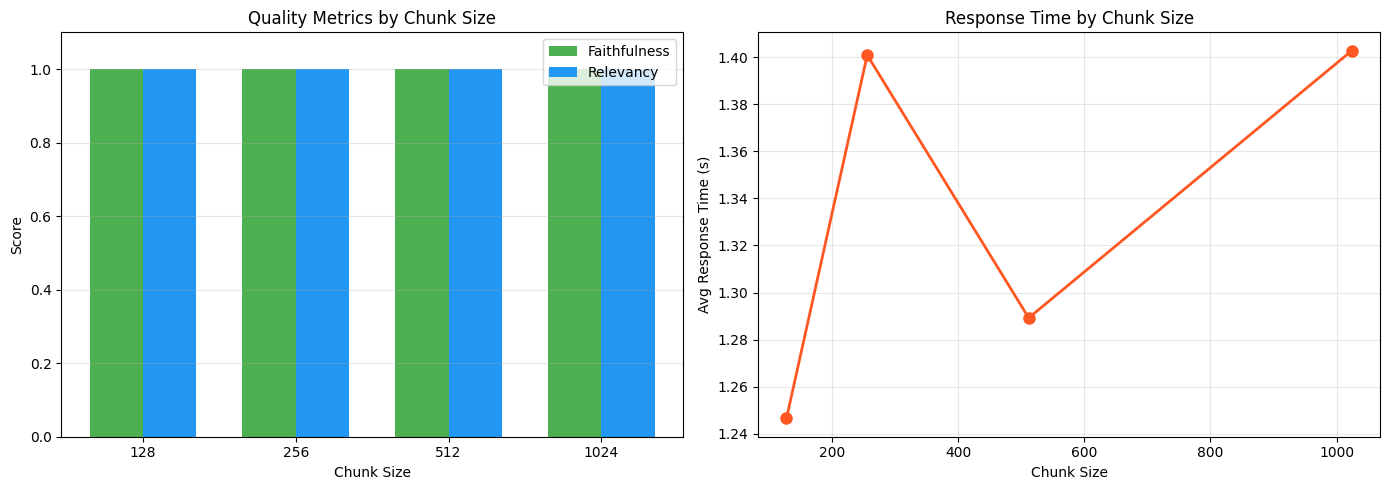

Chart saved to chunk_size_comparison.png


In [15]:
try:
    import matplotlib.pyplot as plt
    
    sizes = [r['chunk_size'] for r in all_results]
    faithfulness = [r['avg_faithfulness'] for r in all_results]
    relevancy = [r['avg_relevancy'] for r in all_results]
    times = [r['avg_response_time'] for r in all_results]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Quality metrics
    x = range(len(sizes))
    width = 0.35
    ax1.bar([i - width/2 for i in x], faithfulness, width, label='Faithfulness', color='#4CAF50')
    ax1.bar([i + width/2 for i in x], relevancy, width, label='Relevancy', color='#2196F3')
    ax1.set_xlabel('Chunk Size')
    ax1.set_ylabel('Score')
    ax1.set_title('Quality Metrics by Chunk Size')
    ax1.set_xticks(x)
    ax1.set_xticklabels(sizes)
    ax1.set_ylim(0, 1.1)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Response time
    ax2.plot(sizes, times, 'o-', color='#FF5722', linewidth=2, markersize=8)
    ax2.set_xlabel('Chunk Size')
    ax2.set_ylabel('Avg Response Time (s)')
    ax2.set_title('Response Time by Chunk Size')
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('chunk_size_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Chart saved to chunk_size_comparison.png")
    
except ImportError:
    print("Install matplotlib for visualization: pip install matplotlib")